Deep dream video example by Vasily Ryazanov
- Based on https://www.tensorflow.org/tutorials/generative/deepdream
- Need to install this lib: https://github.com/kkroening/ffmpeg-python 

In [160]:
import tensorflow as tf
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image

from tqdm.notebook import tqdm
import ffmpeg

In [140]:
# Normalize an image
def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

# Display an image
def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))

In [141]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [142]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return  tf.reduce_sum(losses)


In [143]:
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.float32),)
    )
    def __call__(self, img, steps, step_size):
        print("Tracing")
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                # This needs gradients relative to `img`
                # `GradientTape` only watches `tf.Variable`s by default
                tape.watch(img)
                loss = calc_loss(img, self.model)

            # Calculate the gradient of the loss with respect to the pixels of the input image.
            gradients = tape.gradient(loss, img)

            # Normalize the gradients.
            gradients /= tf.math.reduce_std(gradients) + 1e-8 

            # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
            # You can update the image by directly adding the gradients (because they're the same shape!)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)

        return loss, img

In [144]:
deepdream = DeepDream(dream_model)

In [145]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
    # Convert from uint8 to the range expected by the model.
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0
    while steps_remaining:
        if steps_remaining>100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        steps_remaining -= run_steps
        step += run_steps

        loss, img = deepdream(img, run_steps, tf.constant(step_size))

    result = deprocess(img)
    return result

In [146]:
def process_frame(input_arr):
    names = ['mixed3', 'mixed5']
    layers = [base_model.get_layer(name).output for name in names]

    # Create the feature extraction model
    dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)
    deepdream = DeepDream(dream_model)
    dream_img = run_deep_dream_simple(img=input_arr, 
                                  steps=100, step_size=0.01)
    return dream_img

In [164]:
filepath = './data/IMG_5462.mov'

probe = ffmpeg.probe(filepath)
video_stream = next((stream for stream in probe['streams'] if stream['codec_type'] == 'video'), None)
width = int(video_stream['width'])
height = int(video_stream['height'])
print(width, height)

out, _ = (
    ffmpeg
    .input(filepath)
    .output('pipe:', format='rawvideo', pix_fmt='rgb24')
    .run(capture_stdout=True)
)
video = (
    np
    .frombuffer(out, np.uint8)
    .reshape([-1, height,width, 3])[:, ::4,::4,:]
#     .reshape([-1,width, height, 3])[:, ::4,::4,:]
)

1080 1920


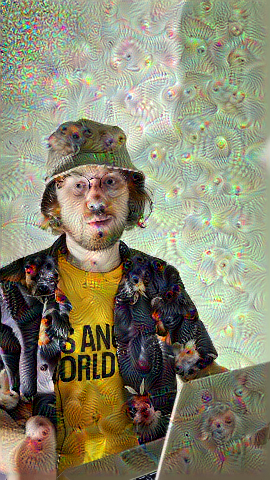

In [165]:
ff = process_frame(video[0])
show(ff)

In [166]:
video_dd = np.array([process_frame(f) for f in tqdm(video)])

In [167]:
def vidwrite(fn, images, framerate=60, vcodec='libx264'):
    if not isinstance(images, np.ndarray):
        images = np.asarray(images)
    n,height,width,channels = images.shape
    process = (
        ffmpeg
            .input('pipe:', 
                   format='rawvideo', 
                   pix_fmt='rgb24', 
                   s='{}x{}'.format(width, height))
            .output(fn, pix_fmt='yuv420p', vcodec=vcodec, r=framerate)
            .overwrite_output()
            .run_async(pipe_stdin=True)
    )
    for frame in tqdm(images):
        process.stdin.write(
            frame
                .astype(np.uint8)
                .tobytes()
        )
    process.stdin.close()
    process.wait()

In [168]:
vidwrite('./data/out3.mp4', video_dd)

In [170]:
len(video)/60

2.0